In [ ]:
import os
import sys
import random
import argparse
import json
import nltk
nltk.download('punkt')
import numpy as np
from tqdm import tqdm
from keras.layers.embeddings import Embedding
from keras.layers import Dense, Input, Dropout, SimpleRNN, Activation, LSTM, Bidirectional, GRU
from keras.models import Model
from keras.preprocessing import sequence
from tensorflow.keras.layers import RepeatVector, Dense, Activation, Lambda,Concatenate,Dot
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from collections import Counter
import string
import re
import argparse

random.seed(42)
np.random.seed(42)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
f = open('./drive/MyDrive/data/train-v2.0.json','r')
data = json.load(f)

In [ ]:
def tokenize(sequence):
    tokens = [token.replace("``", '"').replace("''", '"').lower() for token in nltk.word_tokenize(sequence)]
    return tokens

In [ ]:
def char_2_word_mapping(context,context_tokens):
    w = ''
    current_token_idx = 0 # current word loc
    mapping = dict()

    for char_idx, char in enumerate(context): # step through original characters
        if char != ' ' and char != '\n': # if it's not a space:
            w += char # add to accumulator
            context_token = context_tokens[current_token_idx] # current word token
            if w == context_token: # if the accumulator now matches the current word token
                syn_start = char_idx - len(w) + 1 # char loc of the start of this word
                for char_loc in range(syn_start, char_idx+1):
                    mapping[char_loc] = (w, current_token_idx) # add to mapping
                w = '' # reset accumulator
                current_token_idx += 1

    if current_token_idx != len(context_tokens):
        return None
    else:
        return mapping


## Preprocessing of Data

In [ ]:
def preprocessing(data):
    exm = 0
    exmpl = []
    max_len_context=0
    max_len_question=0

    for a_id in tqdm(range(len(data['data'])), desc="Preprocessing"):
        a_paras = data['data'][a_id]['paragraphs']

        for pid in range(len(a_paras)):
            context = a_paras[pid]['context']
            context = context.replace("''", '" ')
            context = context.replace("``", '" ')

            context_tokens = tokenize(context)

            if len(context_tokens)>250:
                continue

            context = context.lower()

            qas = a_paras[pid]['qas']
            char2wordloc = char_2_word_mapping(context, context_tokens)

            if char2wordloc is None:
                continue

            if len(context_tokens)>max_len_context:
                max_len_context = len(context_tokens)

            for q in qas:
                question = q['question']
                question_tokens = tokenize(question)

                if q['is_impossible']==True or len(question_tokens)>30 or ('why' in question_tokens) or ('how' in question_tokens):
                    continue

                ans_text = (q['answers'][0]['text']).lower()
                a_start_char_loc = q['answers'][0]['answer_start']
                a_end_char_loc = int(a_start_char_loc) + len(ans_text)
                if context[int(a_start_char_loc):a_end_char_loc] != ans_text:
                    continue

                ans_start_wordloc = char2wordloc[a_start_char_loc][1]
                ans_end_wordloc = char2wordloc[a_end_char_loc-1][1]
                assert ans_start_wordloc <= ans_end_wordloc

                ans_tokens = context_tokens[ans_start_wordloc:ans_end_wordloc+1]
                if "".join(ans_tokens) != "".join(ans_text.split()):
                    continue
                if len(question_tokens)>max_len_question:
                    max_len_question = len(question_tokens)

                exmpl.append((' '.join(context_tokens), ' '.join(question_tokens), ' '.join(ans_tokens), ' '.join([str(ans_start_wordloc), str(ans_end_wordloc)])))
                exm += 1
    print("Number Total examples: "+str(exm))
    return exmpl,max_len_context,max_len_question

In [ ]:
exmpl,max_len_context,max_len_question = preprocessing(data)

Preprocessing: 100%|██████████| 442/442 [00:49<00:00,  8.98it/s]

Number Total examples: 71812


In [ ]:
print(exmpl[0])
print(max_len_context)
print(max_len_question)

('beyoncé giselle knowles-carter ( /biːˈjɒnseɪ/ bee-yon-say ) ( born september 4 , 1981 ) is an american singer , songwriter , record producer and actress . born and raised in houston , texas , she performed in various singing and dancing competitions as a child , and rose to fame in the late 1990s as lead singer of r & b girl-group destiny \'s child . managed by her father , mathew knowles , the group became one of the world \'s best-selling girl groups of all time . their hiatus saw the release of beyoncé \'s debut album , dangerously in love ( 2003 ) , which established her as a solo artist worldwide , earned five grammy awards and featured the billboard hot 100 number-one singles " crazy in love " and " baby boy " .', 'when did beyonce start becoming popular ?', 'in the late 1990s', '50 53')
250
30


In [ ]:
def glove_process():
    _pad = b"<pad>"
    _unk = b"<unk>"
    _extra_vocab = [_pad, _unk]
    padid = 0
    unkid = 1
    vocab_size = int(4e5)

    emd_mat = np.zeros((vocab_size+len(_extra_vocab),100))
    word2idx = {}
    idx2word = {}

    idx = 0

    for w in _extra_vocab:
        word2idx[w]=idx
        idx2word[idx]=w
        idx+=1

    f = open('./drive/MyDrive/data/glove.6B.100d.txt','r')

    for line in tqdm(f, total=vocab_size):
        line = line.lstrip().rstrip().split(" ")
        w = line[0]
        embedding = list(map(float, line[1:]))
        emd_mat[idx, :] = embedding
        word2idx[w] = idx
        idx2word[idx] = w
        idx += 1
    return emd_mat, word2idx, idx2word

In [ ]:
vocab_size = int(4e5)+2
em,word2idx,idx2word = glove_process()

100%|██████████| 400000/400000 [00:14<00:00, 28327.41it/s]


In [ ]:
def sentences_to_indices(X, word_to_index, max_len):
    m = X.shape[0]
    X_indices = np.zeros((m,max_len))

    for i in range(m):

        # Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        sentence_words = X[i].lower().split()

        # Initialize j to 0
        j = 0

        # Loop over the words of sentence_words
        for w in sentence_words:
            # Set the (i,j)th entry of X_indices to the index of the correct word.
            if w in word_to_index.keys():
                X_indices[i, j] = word_to_index[w]
            else:
                X_indices[i, j] = word_to_index[b"<unk>"]
            # Increment j to j + 1
            j += 1

    ### END CODE HERE ###

    return X_indices

In [ ]:
import math
b_size=64
n = math.floor((len(exmpl)/b_size))*b_size
m = np.array(exmpl[:n])

In [ ]:
con = sentences_to_indices(m[:,0],word2idx,max_len_context)
qe = sentences_to_indices(m[:,1],word2idx,max_len_question)

In [ ]:
def pretrained_embedding_layer(voc_len,emb_mat):
    embedding_layer = Embedding(voc_len, 100,trainable=False)
    embedding_layer.build((None,))
    embedding_layer.set_weights([emb_mat])

    return embedding_layer

In [ ]:
concatenator = Concatenate(axis=2)

In [ ]:
def encoder(embedding_context,embedding_question):
    H_P = Bidirectional(GRU(150,return_sequences=True))(embedding_context)
    H_Q = Bidirectional(GRU(150,return_sequences=True))(embedding_question)
    return H_P,H_Q

In [ ]:
def matrix_multiplication(mat, weight):
  # [batch_size, seq_len, hidden_size] * [hidden_size, p] = [batch_size, seq_len, p]
  mat_shape = mat.get_shape().as_list()  # shape - ijk
  weight_shape = weight.get_shape().as_list()  # shape -kl
  assert (mat_shape[-1] == weight_shape[0])
  mat_reshape = tf.reshape(mat, [-1, mat_shape[-1]])  # [batch_size * n, m]
  mul = tf.matmul(mat_reshape, weight)  # [batch_size * n, p]
  return tf.reshape(mul, [-1, mat_shape[1], weight_shape[-1]])  # reshape to batch_size, seq_len, p


In [ ]:
def highway_layer(x,size,cb=-1):
  W_T = tf.Variable(tf.random.truncated_normal([size, size], stddev=0.1), name="weight_transform")
  b_T = tf.Variable(tf.constant(cb, shape=[size],dtype='float32'), name="bias_transform")

  W = tf.Variable(tf.random.truncated_normal([size, size], stddev=0.1), name="weight")
  b = tf.Variable(tf.constant(0.1, shape=[size],dtype='float32'), name="bias")

  T = tf.sigmoid(matrix_multiplication(x, W_T) + b_T, name="transform_gate")
  H = tf.nn.relu(matrix_multiplication(x, W) + b, name="activation")

  C = tf.subtract(1.0, T, name="carry_gate")

  y = tf.add(tf.multiply(H, T), tf.multiply(x, C), "y")
  return y

In [ ]:
def basic_attention(H_P,H_Q):
    z = tf.matmul(H_P,tf.transpose(H_Q,perm=[0, 2, 1]))
    z = tf.nn.softmax(z, 2)
    z = tf.matmul(z,H_Q)
    concate =  tf.concat([H_P, z], axis=2)
    return concate

In [ ]:
def mask_sm(logits,dim):
    mask = (logits==0)
    mask_exp = (tf.cast(mask, 'float'))*(1e-30)
    mask_logits = tf.add(logits,mask_exp)
    ans = tf.nn.softmax(mask_logits, dim)
    return ans

In [ ]:
def bidaf_attention(H_P,H_Q):
    S_W = tf.Variable(tf.initializers.GlorotUniform()(shape=[3*300]))
    c_expand = tf.expand_dims(H_P,2)
    q_expand = tf.expand_dims(H_Q,1)
    c_pointWise_q = c_expand * q_expand
    c_input = tf.tile(c_expand, [1, 1, tf.shape(H_Q)[1], 1])
    q_input = tf.tile(q_expand, [1, tf.shape(H_P)[1], 1, 1])
    concat_input = tf.concat([c_input, q_input, c_pointWise_q], -1)
    similarity=tf.reduce_sum(concat_input * S_W, axis=3)

    #c2q_dist = tf.nn.softmax(similarity, 2)
    c2q_dist = mask_sm(similarity, 2)

    c2q = tf.matmul(c2q_dist, H_Q)
    S_max = tf.reduce_max(similarity, axis=2)

    #c_dash_dist = tf.nn.softmax(S_max,1)
    c_dash_dist = mask_sm(S_max,1)

    c_dash_dist_expand = tf.expand_dims(c_dash_dist, 1)
    c_dash = tf.matmul(c_dash_dist_expand, H_P)
    c_c2q = H_P * c2q
    c_c_dash = H_P * c_dash
    output = tf.concat([c2q, c_c2q, c_c_dash], axis=2)
    ble_rep = tf.concat([H_P, output], axis=2)
    concate  = Bidirectional(GRU(150,return_sequences=True))(ble_rep)
    return concate

In [ ]:
def decoder(concate_final):
    s = Dense(1,activation=None)(concate_final)
    s = tf.squeeze(s, axis=[2])
    #s = mask_sm(s,0)

    e = Dense(1,activation=None)(concate_final)
    e = tf.squeeze(e, axis=[2])
    #e = mask_sm(e,0)
    return s,e

In [ ]:
def modelf(b_size,attention_type="basic"):
    context_indices = Input(shape = (max_len_context,),batch_size=b_size)
    question_indices = Input(shape = (max_len_question,),batch_size=b_size)

    embedding_layer = pretrained_embedding_layer(vocab_size,em)
    embedding_context = embedding_layer(context_indices)
    embedding_question = embedding_layer(question_indices)

    dim = embedding_context.get_shape().as_list()[-1]

    for i in range(2):
      embedding_context = highway_layer(embedding_context,dim,cb=-1)
      embedding_question = highway_layer(embedding_question,dim,cb=-1)
    H_P,H_Q = encoder(embedding_context,embedding_question)

    if attention_type=="basic":
        concate = basic_attention(H_P,H_Q)
    else:
        #Bidef attention
        concate = bidaf_attention(H_P,H_Q)

    concate_final = Dense(200,activation='relu')(concate)

    s,e = decoder(concate_final)

    model = Model(inputs=[context_indices,question_indices],outputs=tf.transpose(tf.stack([s,e]),[1, 0, 2]))
    return model

In [ ]:
model = modelf(b_size,"bidef")

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(64, 250)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(64, 30)]           0           []                               
                                                                                                  
 embedding (Embedding)          multiple             40000200    ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 tf.reshape (TFOpLambda)        (16000, 100)         0           ['embedding[0][0]']          

In [ ]:
def custom_loss(y_true,y_pred):
    loss_start = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=y_pred[0,:], labels=y_true[0,:])
    loss_start_m = tf.reduce_mean(loss_start)
    loss_end = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=y_pred[1,:], labels=y_true[1,:])
    loss_end_m = tf.reduce_mean(loss_end)
    loss = loss_start_m + loss_end_m
    return loss

In [ ]:
#model.load_weights('./model/model_with_bidef_attention_p'+str(max_len_context)+'_q'+str(max_len_question))
opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999,clipvalue=5.0)
model.compile(loss = custom_loss, optimizer = opt, metrics = ['accuracy'])

In [ ]:
def op(y):
    l = []
    for i in range(0,len(y)):
        t=[]
        for w in y[i].split():
            t.append(int(w))
        l.append(t)
    return l

In [ ]:
f = open('./drive/MyDrive/data/dev-v2.0.json','r')
val_data = json.load(f)
val_exmpl,val_max_len_context,val_max_len_question = preprocessing(val_data)
val_m = np.array(val_exmpl[:])
val_con = sentences_to_indices(val_m[:,0],word2idx,max_len_context)
val_qe = sentences_to_indices(val_m[:,1],word2idx,max_len_question)
y1 = np.array(op(val_m[:,3]))

Preprocessing: 100%|██████████| 35/35 [00:03<00:00, 10.53it/s]


Number Total examples: 4820


In [ ]:
y = np.array(op(m[:,3]))
h = model.fit([con,qe],y,epochs=5,batch_size=b_size,validation_data=([val_con[:4800],val_qe[:4800]],y1[:4800]))

Epoch 1/5
 148/1122 [==>...........................] - ETA: 13:29 - loss: 8.8944 - accuracy: 0.0520

KeyboardInterrupt: ignored

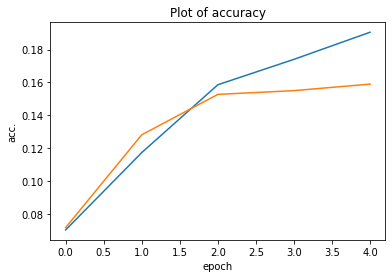

In [ ]:
import matplotlib.pyplot as plt
plt.xlabel('epoch')
plt.ylabel('acc.')
plt.title('Plot of accuracy')
x = range(0,5)
y1 = h.history['accuracy']
y2 = h.history['val_accuracy']
plt.plot(x,y1)
plt.plot(x,y2)
plt.savefig('acc_plot.png')

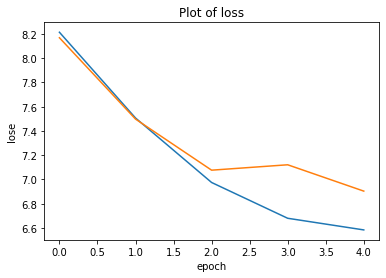

In [ ]:
import matplotlib.pyplot as plt
plt.xlabel('epoch')
plt.ylabel('lose')
plt.title('Plot of loss')
x = range(0,5)
y1 = h.history['loss']
y2 = h.history['val_loss']
plt.plot(x,y1)
plt.plot(x,y2)
plt.savefig('loss_plot.png')

In [ ]:
import pickle
pickle.dump(h.history,open("history_1",'wb'))

In [ ]:
model.save_weights('model_with_bidef_attention_p'+str(max_len_context)+'_q'+str(max_len_question))

In [ ]:
model.save('model_40.h5')

TypeError: ignored

# Performance of Model

In [ ]:
f = open('./drive/MyDrive/data/dev-v2.0.json','r')
test_data = json.load(f)

In [ ]:
test_exmpl,test_max_len_context,test_max_len_question = preprocessing(test_data)

Preprocessing: 100%|██████████| 35/35 [00:07<00:00,  4.46it/s]

Number Total examples: 4820


In [ ]:
test_m = np.array(test_exmpl[:])
test_con = sentences_to_indices(test_m[:,0],word2idx,max_len_context)
test_qe = sentences_to_indices(test_m[:,1],word2idx,max_len_question)
y1 = np.array(op(test_m[:,3]))
prediction = model.predict([test_con,test_qe],batch_size=1)

In [ ]:
def smart_span(prediction,con_len):
    prediction[:,0,:] = tf.nn.softmax(prediction[:,0,:],axis=1)
    prediction[:,1,:] = tf.nn.softmax(prediction[:,1,:],axis=1)

    b = prediction.shape[0]
    start = np.zeros(b,dtype='int64')
    end = np.zeros(b,dtype='int64')
    max_prob = np.zeros(b)

    for i in range(b):
        maxprod = 0
        chosen_start = 0
        chosen_end = 0

        for j in range(con_len[i]-16):
            end_sub = prediction[i,1,j:j+16]
            end_max_prob = np.amax(end_sub)
            end_in = np.argmax(end_sub)

            start_prob = prediction[i,0,j]
            prod = start_prob*end_max_prob

            if prod>maxprod:
                maxprod=prod
                chosen_start = j
                chosen_end = chosen_start + end_in
        start[i] = chosen_start
        end[i] = chosen_end
    return start,end

In [ ]:
p1 = prediction[1]
#p1 = tf.nn.softmax(p1,0)
ans = tf.math.argmax(p1,axis=1)
l = ans.numpy()

In [ ]:
con_len = []
con_text = test_m[:,0]
for i in range(con_text.shape[0]):
    context_tokens = tokenize(con_text[i])
    con_len.append(len(context_tokens))
start,end = smart_span(prediction,con_len)

In [ ]:
def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

In [ ]:
def f1_score(prediction, ground_truth):
    prediction_tokens = normalize_answer(prediction).split()
    ground_truth_tokens = normalize_answer(ground_truth).split()
    common = Counter(prediction_tokens) & Counter(ground_truth_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        return 0,0,0
    precision = 1.0 * num_same / len(prediction_tokens)
    recall = 1.0 * num_same / len(ground_truth_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1,precision,recall

In [ ]:
def exact_match_score(prediction, ground_truth):
    return (normalize_answer(prediction) == normalize_answer(ground_truth))

In [ ]:
predicted_ans = []
for i in range(con_text.shape[0]):
    context_tokens = tokenize(con_text[i])
    ans=""
    for w in context_tokens[start[i]:end[i]+1]:
        ans+=w
        ans+=' '
    predicted_ans.append(ans)
predicted_ans = predicted_ans

In [ ]:
crct_ans = test_m[:,2]
f1=0
em=0
prec=0
recall=0
for i in range(crct_ans.shape[0]):
    t1,t2,t3 = f1_score(predicted_ans[i], crct_ans[i])
    f1+=t1
    prec+=t2
    recall+=t3
    if exact_match_score(normalize_answer(predicted_ans[i]), normalize_answer(crct_ans[i])):
        em+=1
f1 = f1/crct_ans.shape[0]
em = em/crct_ans.shape[0]
prec=prec/crct_ans.shape[0]
recall=recall/crct_ans.shape[0]
print("F1 score: "+str(100*f1))
print("EM score: "+str(100*em))
print("Precision score: "+str(100*prec))
print("Recall score: "+str(100*recall))

F1 score: 21.598904497343792
EM score: 11.763485477178422
Precision score: 21.682572355030896
Recall score: 27.193539113345288


# Test Model

In [ ]:
def sen_2_ind(x,word2idx,max_len):
    x_ind = np.zeros((1,max_len))
    sentence_words = x.lower().split()
    # Initialize j to 0
    j = 0
     # Loop over the words of sentence_words
    for w in sentence_words:
        # Set the (i,j)th entry of X_indices to the index of the correct word.
        if w in word2idx.keys():
            x_ind[0,j] = word2idx[w]
        else:
            x_ind[0,j] = word2idx[b"<unk>"]
            # Increment j to j + 1
        j += 1
    return x_ind


In [ ]:
def test_preprocessing(context,question):
    context = context.replace("''", '" ')
    context = context.replace("``", '" ')
    context_tokens = tokenize(context)
    if len(context_tokens)>250:
        print("Please enter context of length <=100")
        return

    question_tokens = tokenize(question)
    if len(question_tokens)>30 or ('why' in question_tokens) or ('how' in question_tokens):
        print("Please enter a valid question")
    test_ex = []
    test_ex.append((' '.join(context_tokens), ' '.join(question_tokens)))
    con = sen_2_ind(test_ex[0][0],word2idx,max_len_context)
    qe = sen_2_ind(test_ex[0][1],word2idx,max_len_question)
    return con,qe


In [ ]:
def col_print(s):
    print("\033[34m"+s+'\033[0m')

In [ ]:
con_file = open("./drive/MyDrive/data/Context.txt","r")
qe_file = open("./drive/MyDrive/data/Question.txt","r")
test_context = con_file.read()
test_question = qe_file.read()
#actual_ans = "Robert Boyle"
c,q = test_preprocessing(test_context,test_question)
prediction = model.predict([c,q],batch_size=1)

con_tokens = tokenize(test_context)
con_len.append(len(context_tokens))
start,end = smart_span(prediction,con_len)
ans=""
for w in con_tokens[start[0]:end[0]+1]:
    ans+=w
    ans+=' '
col_print("Context:")
print(test_context)
col_print("Question:")
print(test_question)
#col_print("Correct answer:")
#print(actual_ans)
col_print("Predicted ans:")
print(ans)

Context:
 Prime numbers of this form are known as factorial primes. Other primes where either p + 1 or p − 1 is of a particular shape include the Sophie Germain primes (primes of the form 2p + 1 with p prime), primorial primes, Fermat primes and Mersenne primes, that is, prime numbers that are of the form 2p − 1, where p is an arbitrary prime. The Lucas–Lehmer test is particularly fast for numbers of this form. This is why the largest known prime has almost always been a Mersenne prime since the dawn of electronic computers.
Question:
Of what form are Mersenne primes?
Predicted ans:
factorial primes 


# References

https://arxiv.org/abs/1611.01603 <br>
https://towardsdatascience.com/nlp-building-a-question-answering-model-ed0529a68c54